VXOCLS
CPIAUCSL
UNRATE
INDPRO
UMCSENT
STLFSI2
FEDFUNDS
T10Y2Y
PCEPI
PAYEMS
M2SL
RETAILSMSA
📌 Selected features via LASSO:
STLFSI2              4.046353
PAYEMS_zscore       -1.319916
M2SL_6m_chg          0.983920
FEDFUNDS_6m_chg     -0.797211
PCEPI               -0.773289
INDPRO_6m_chg        0.429856
T10Y2Y_6m_chg        0.355972
RETAILSMSA_6m_chg    0.333431
INDPRO_3m_chg        0.264771
FEDFUNDS             0.205168
STLFSI2_zscore       0.088534
M2SL_zscore         -0.040466
dtype: float64


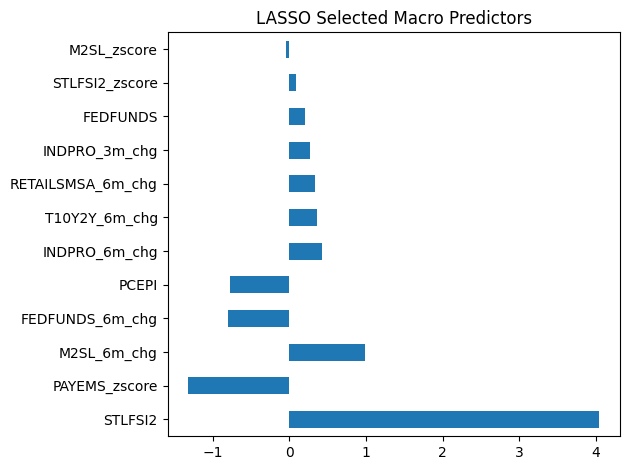

In [ ]:
from fredapi import Fred
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Replace this with your own API key
fred = Fred(api_key="")

# Define FRED series
fred_series = {
    'VXOCLS': 'VIX proxy (target)',
    'CPIAUCSL': 'Inflation - CPI',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'UMCSENT': 'Consumer Sentiment',
    'STLFSI2': 'Financial Stress Index',
    'FEDFUNDS': 'Fed Funds Rate',
    'T10Y2Y': 'Yield Curve 10Y-2Y',
    'PCEPI': 'PCE Inflation',
    'PAYEMS': 'Nonfarm Payrolls',
    'M2SL': 'Money Supply M2',
    'RETAILSMSA': 'Retail Sales'
}

start = '1990-01-01'
end = '2024-12-31'
data = pd.DataFrame()

for code in fred_series:
    print(code)
    data[code] = fred.get_series(code, observation_start=start, observation_end=end)

data = data.resample('ME').last().dropna()
data['VXO_next'] = data['VXOCLS'].shift(-1)
data.dropna(inplace=True)

# Feature engineering
for col in data.columns:
    if col != 'VXO_next':
        data[f'{col}_3m_chg'] = data[col].pct_change(3)
        data[f'{col}_6m_chg'] = data[col].pct_change(6)
        data[f'{col}_zscore'] = (data[col] - data[col].rolling(12).mean()) / data[col].rolling(12).std()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

features = [col for col in data.columns if 'VXO' not in col]
X = data[features]
y = data['VXO_next']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=0, max_iter=50000).fit(X_scaled, y)
coefs = pd.Series(lasso.coef_, index=features)
selected_features = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print("📌 Selected features via LASSO:")
print(selected_features)

# Plot
selected_features.plot(kind='barh', title="LASSO Selected Macro Predictors")
plt.tight_layout()
plt.show()

In [3]:
columns = ["VXO_next", "VXOCLS"]
data[columns]

,VXO_next,VXOCLS
1995-03-31,14.56,13.58
1995-05-31,12.88,14.56
1995-06-30,11.99,12.88
1995-08-31,12.99,11.99
1995-09-30,12.05,12.99
...,...,...
2021-02-28,19.32,28.51
2021-03-31,17.27,19.32
2021-04-30,13.17,17.27
2021-06-30,16.21,13.17


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

selected_feature_names = selected_features.index.tolist()
X_selected = X[selected_feature_names]
# X_selected = X[features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

right_direction = 0
total = 0

previous_true = None
for pred, true in zip(y_pred, y_test):
    print(f"Predicted: {pred:.2f}, Actual: {true:.2f}")
    if previous_true is not None:
        if (pred > previous_true and true > previous_true) or (pred < previous_true and true < previous_true):
            right_direction += 1
        total += 1
    previous_true = true

print(right_direction, total)

R² Score: 0.5278109640438642
RMSE: 5.9084203141616864
Predicted: 20.45, Actual: 16.84
Predicted: 13.85, Actual: 13.62
Predicted: 40.86, Actual: 45.85
Predicted: 23.27, Actual: 16.11
Predicted: 18.73, Actual: 13.17
Predicted: 29.33, Actual: 22.59
Predicted: 26.33, Actual: 21.70
Predicted: 16.90, Actual: 16.69
Predicted: 16.07, Actual: 22.16
Predicted: 15.49, Actual: 13.43
Predicted: 31.28, Actual: 35.28
Predicted: 20.09, Actual: 20.82
Predicted: 15.43, Actual: 11.16
Predicted: 22.54, Actual: 22.89
Predicted: 28.77, Actual: 25.41
Predicted: 25.34, Actual: 19.28
Predicted: 14.83, Actual: 18.23
Predicted: 14.25, Actual: 13.58
Predicted: 12.56, Actual: 19.85
Predicted: 15.33, Actual: 11.35
Predicted: 12.74, Actual: 11.12
Predicted: 22.44, Actual: 23.75
Predicted: 15.46, Actual: 13.44
Predicted: 23.63, Actual: 44.11
Predicted: 19.24, Actual: 16.54
Predicted: 25.96, Actual: 22.98
Predicted: 12.67, Actual: 10.36
Predicted: 27.56, Actual: 23.77
Predicted: 27.05, Actual: 23.51
Predicted: 14.86, 

In [5]:
coef_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nCoefficients:")
print(coef_df)


Coefficients:
              Feature  Coefficient
2         M2SL_6m_chg    65.063620
5       INDPRO_6m_chg    43.630821
8       INDPRO_3m_chg     6.228189
0             STLFSI2     4.768008
7   RETAILSMSA_6m_chg     3.834070
11        M2SL_zscore    -2.742016
1       PAYEMS_zscore    -1.683120
3     FEDFUNDS_6m_chg    -1.245170
9            FEDFUNDS     0.386338
10     STLFSI2_zscore     0.188039
4               PCEPI    -0.065722
6       T10Y2Y_6m_chg     0.048252


In [8]:
most_recent_data = data.iloc[-1]
print("\nMost recent data for prediction:")
print(most_recent_data)
lr_pred = lr.predict([most_recent_data])[0]
print(f"\nPredicted VXO_next for most recent data: {lr_pred:.2f}")


Most recent data for prediction:
VXOCLS                   16.210000
CPIAUCSL                271.965000
UNRATE                    5.400000
INDPRO                  100.066800
UMCSENT                  81.200000
STLFSI2                  -0.934700
FEDFUNDS                  0.100000
T10Y2Y                    1.050000
PCEPI                   109.275000
PAYEMS               146759.000000
M2SL                  20628.700000
RETAILSMSA           528600.000000
VXO_next                 17.870000
VXOCLS_3m_chg            -0.160973
VXOCLS_6m_chg            -0.229929
VXOCLS_zscore            -1.058317
CPIAUCSL_3m_chg           0.026876
CPIAUCSL_6m_chg           0.037856
CPIAUCSL_zscore           1.803325
UNRATE_3m_chg            -0.114754
UNRATE_6m_chg            -0.194030
UNRATE_zscore            -0.917735
INDPRO_3m_chg             0.019084
INDPRO_6m_chg             0.018970
INDPRO_zscore             0.987337
UMCSENT_3m_chg           -0.043581
UMCSENT_6m_chg            0.006196
UMCSENT_zscore       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 49 features, but LinearRegression is expecting 12 features as input.